# El modelo epidémico de SIR
Una descripción matemática simple de la propagación de una enfermedad en una población es el llamado modelo SIR, que divide la población (fija) de N individuos en tres "compartimentos" que pueden variar en función del tiempo, t:

* S(t) son aquellos susceptibles pero aún no infectados con la enfermedad;
* I(t) es el número de individuos infecciosos;
* R(t) son aquellas personas que se han recuperado de la enfermedad y ahora tienen inmunidad.

El modelo SIR describe el cambio en la población de cada uno de estos compartimentos en términos de dos parámetros,  beta y  gamma.  
- Beta describe la tasa de contacto efectiva de la enfermedad: un individuo infectado entra en contacto con  beta*N otros individuos por unidad de tiempo (de los cuales la fracción que es susceptible a contraer la enfermedad es S/N).  
- Gamma es la tasa de recuperación promedio: es decir, 1/ gamma es el período de tiempo promedio durante el cual una persona infectada puede transmitirlo.

Las ecuaciones diferenciales que describen este modelo fueron derivadas primero por Kermack y McKendrick [ Proc. R. Soc. A , 115 , 772 (1927)]:

\begin{align*}
\frac{\mathrm{d}S}{\mathrm{d}t} &= -\frac{\beta S I}{N},\\
\frac{\mathrm{d}I}{\mathrm{d}t} &= \frac{\beta S I}{N} - \gamma I,\\
\frac{\mathrm{d}R}{\mathrm{d}t} &= \gamma I.
\end{align*}

El siguiente código de Python integra estas ecuaciones para una enfermedad caracterizada por los parámetros  beta=0.2, gamma=10  en una población de N=1000 (quizás 'gripe en una escuela ) El modelo se inicia con una sola persona infectada el día 0: I(0)=1. Las curvas trazadas de S(t), I(t) y R(t) están diseñadas para verse un poco mejor que los valores predeterminados de Matplotlib.

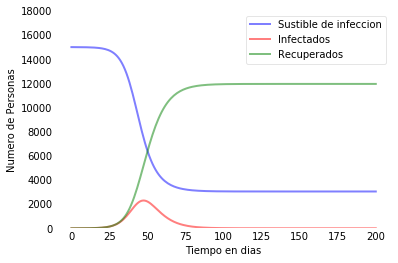

2.0


In [166]:
#Importar las librerias.
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total de la poblacion
N = 15000
# Numero Inicial de Infectados
I0 = 1
# Numero de Recuperados
R0 = 0
# Todos los demás, S0, son susceptibles a la infección inicialmente.
S0 = N - I0 - R0
# Tasa de contacto, beta (nivel de repoductividad del virus) 
# La tasa de recuperación media, gamma,(1/días) Una persona se recupera en 15 dias.
beta, gamma = 0.4, 1.0/5
# Una cuadrícula de puntos de tiempo (en días)
t = np.linspace(0, 200, 200)


# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = S0, I0, R0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados


#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
ax.set_ylim(0,N*1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

Ro = beta/gamma
print(Ro)


## Generar la prediccion del modelos SIR

 Se debe  estimar el valor de 
- β 
- γ

Para ajustar el modelo SIR con los casos confirmados reales (el número de personas infecciosas) del Ecuador.
 
 Para ello deben seguir el siguiente tutorial 
 https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
 


In [173]:
import numpy as np
import pandas as pd
from csv import reader
from csv import writer
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import argparse
import sys
import json
import ssl
import urllib.request

country=Ecuador, beta=0.40000000, gamma=0.40000000, r_0:1.00000000
Fin


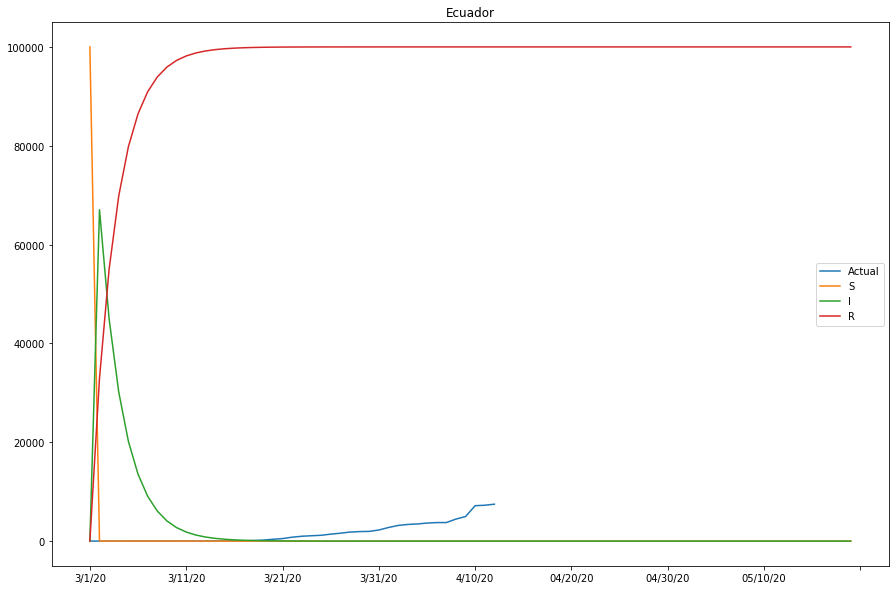

In [196]:
# Implementar y explicar la predicion del modelo SIR para el Ecuador

# 1. Implementar solo teniendo en cuenta los casos confirmados


class Learner(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0


    def load_confirmed(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data):
        predict_range = self.predict_range
        new_index = self.extend_index(data.index, predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, solve_ivp(SIR, [0, size], [self.s_0,self.i_0,self.r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        data = self.load_confirmed(self.country)
        
        optimal = minimize(
            loss,
            [0.001, 0.001],
            args=(data, self.s_0, self.i_0, self.r_0),
            method='L-BFGS-B',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )
        
        beta, gamma = optimal.x
        new_index, extended_actual, prediction = self.predict(beta, gamma, data)
        
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction.y[0],
            'I': prediction.y[1],
            'R': prediction.y[2]
        }, index=new_index)
        
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
    
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")


def loss(point, data, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0, i_0, r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))


learner = Learner('Ecuador', loss, '3/1/20', 80, 100000, 1, 0)
     
learner.train()
print('Fin')

country=Ecuador, beta=0.00000001, gamma=0.00840083, r_0:0.00000119


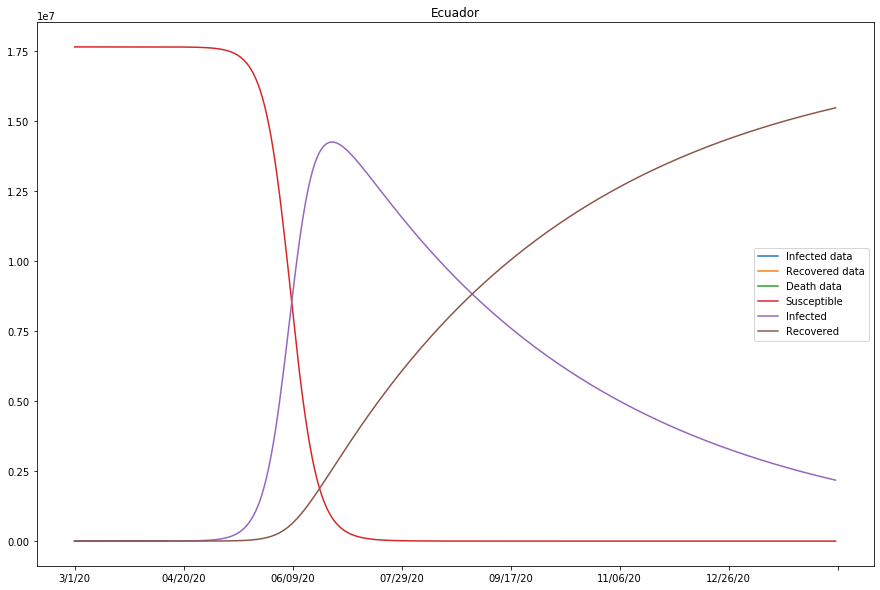

In [179]:
# 2. Implementar teniendo en cuenta los casos confirmados y recuperados.

class Learner_recumerados(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0


    def load_confirmed(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_recovered(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_dead(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        data = (self.load_confirmed(self.country) - recovered - death)
        
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death, 'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
    
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2


learner_recumerados = Learner_recumerados('Ecuador', loss, '3/1/20', 350, 17643060, 1, 0)
     
learner_recumerados.train()


## Calculos de incidencia

Para obtener metricas de incidencia se debe calcular la tasa de prevalencia, incidencia y la relacion, para esto leer y obtener estos datos con la ultima lectura.

https://www.paho.org/hq/index.php?option=com_content&view=article&id=14402:indicadores-de-salud-aspectos-conceptuales-y-operativos-seccion-2&catid=9894&limitstart=2&Itemid=101&lang=es

In [195]:
# Implementar
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
country_df = df[df['Country/Region'] == 'Ecuador']
valor =  country_df.iloc[0].loc['3/1/20':]
incidencia = ((valor[len(valor)-1]-valor[len(valor)-2])/17643060)*100000

tasa_prevalencia = (valor[len(valor)-1]/17643060)*100000
#Prevalencia = Incidencia * t (duración media de la enfermedad)
prevalencia = incidencia*(tasa_prevalencia/incidencia)

print('Incidencia: ',incidencia,' cada 100000 personas')
print('Tasa de Prevalencia: ',tasa_prevalencia, ' cada 100000 personas')
print('Prevalencia: ',prevalencia)

Incidencia:  1.1846017640930768  cada 100000 personas
Tasa de Prevalencia:  42.31692234793738  cada 100000 personas
Prevalencia:  42.31692234793738


## Analisis
En la prediccion del modelo SIR solo teniendo en cuenta los casos confirmados en Ecuador, notamos que la la cura de contagiados con coincide con los valores reales actuales, por otro lado teniendo en cuenta los casos confirmados y recuperados se observa que el pico de la curva o maximo de contagiados es aproximadamente 14.5 millones de personas.

## Conclusiones
Sin concideramos solamente los datos confirmados en Ecuador no obtenemos una prediccion que ajuste a los datos actuales reales. sin embargo el modelo SIR nos dan datos extremadamente alertadores, como nos indica la pagina lewuathe estas estadisticas no pueden ser concideradas oficiales.    

## Opinion
No podemos fiarnos de los resultados que nos indican estos analisis puesto que si llega a tener mas de 14 millones de casos en el mes de julio, el país no podrá super dicha crisis, por lo tanto, es necesario implementar nuevas y mejores medidas que permitan frentar el aumento de numero de contagiados.

# Referencias:
- https://www.agenciasinc.es/Reportajes/Un-modelo-un-teorema-y-teoria-de-juegos-contra-el-coronavirus
- https://rpubs.com/dsfernandez/422937
- https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2
